In [50]:
%matplotlib inline
%qtconsole

import os
import cPickle
import numpy as np
import pandas
from scipy import linalg

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset, date2num, num2date
from datetime import datetime, timedelta
from scipy import stats
import numpy as np
import os.path
import string

import t_subsample
from getSkillGridded import getSkillGridded
from load_gridded_data import read_gridded_data_CMIP5_model
from gridAvg import gridAvg

In [3]:
data_dir = '/Users/dan/Desktop/CCSM4_ctrl/'
data_file = 'tas_sfc_Amon_CCSM4_past1000_085001-185012.nc'
data_vars = {'tas_sfc_Amon':0}
outtimeavg = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

#dd=read_gridded_data_CMIP5_model(data_dir,data_file,data_vars,outtimeavg,detrend=True)
dd=read_gridded_data_CMIP5_model(data_dir,data_file,data_vars,outtimeavg,detrend=None)



Reading file:  /Users/dan/Desktop/CCSM4_ctrl//tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.07237e-07  , std-dev= 1.88994
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.44248843524e-08  , std-dev= 0.831738641116


In [3]:
#A = np.matrix('.7 .1;.2 .6')
#x0 = np.matrix('0;0')

#x = np.matrix('0;0')

#for ii in np.arange(0,1000):
#    last = x[-2:]
#    a = np.random.randn(2,1)
#    x = np.concatenate([x A*last+eta])



In [114]:
## Make a gridded average of normalized proxy data to use as a mask on the CCSM4 output

proxy_pandas_metafile = '/Users/dan/Dropbox (MIT)/2016-2017/LMR/NCDC_v0.1.0all_Metadata.df.pckl'
proxy_pandas_datafile = '/Users/dan/Dropbox (MIT)/2016-2017/LMR/NCDC_v0.1.0all_Proxies.df.pckl'

proxy_meta = pandas.read_pickle(proxy_pandas_metafile)
proxy_data = pandas.read_pickle(proxy_pandas_datafile)

# Reformat the proxy_meta to get rid of special characters
proxy_meta.columns = [x.strip().replace(' ','_') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('(','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace(')','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('.','') for x in proxy_meta.columns]

# Change the metadata file so that indices are NCDC IDs (better matchup with data file)
proxy_meta.index = proxy_meta['NCDC_ID']

proxy_meta['Archive_type'] = proxy_meta['Archive_type'].str.replace(' ','_')

# sort the metadata to have the same order as the data file
proxy_meta = proxy_meta.loc[proxy_data.columns]

import gridAvg
reload( gridAvg )
from gridAvg import gridAvg
xRes = np.mean(np.diff(dd['tas_sfc_Amon']['lon']))
yRes = np.mean(np.diff(dd['tas_sfc_Amon']['lat']))
gridded, pmg, lat_g,lon_g = gridAvg(proxy_meta,proxy_data[0:1000],xRes,yRes)

# Make a mask from the data
dmask = (np.nansum(gridded,0)!=0)



In [113]:
# Mask with data for a pseudoproxy-like experiment
mask = dmask

data = dd['tas_sfc_Amon']['value'][:,mask]
time = np.arange(850,1851)

ccsm4DF = pandas.DataFrame(data=data,index=time)
rdf,G,c0,ct = getSkillGridded(ccsm4DF,1,[1100,1450],[1800,1850],True,8);

# Put RMSE on a spatial grid
m,n = mask.shape
rmap = np.empty([m,n])*np.nan
rmap[mask] = np.squeeze(rdf.values)

# Mask and plot with basemap

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

x,y = np.meshgrid(lon_g[:-1], lat_g[:])

ax = plt.gca()
masked_array = np.ma.array(rmap, mask=np.isnan(rmap))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,rmap,shading='flat',cmap=cmap,latlon=True);
im2 = m.pcolormesh(x,y,masked_array,shading='flat',cmap=cmap,latlon=True);
m.drawcoastlines();
cbar = plt.colorbar(shrink=.7)
plt.title('CCSM4 RMSE',size=20)
cbar.set_label('Number of records')

NameError: name 'dmask' is not defined

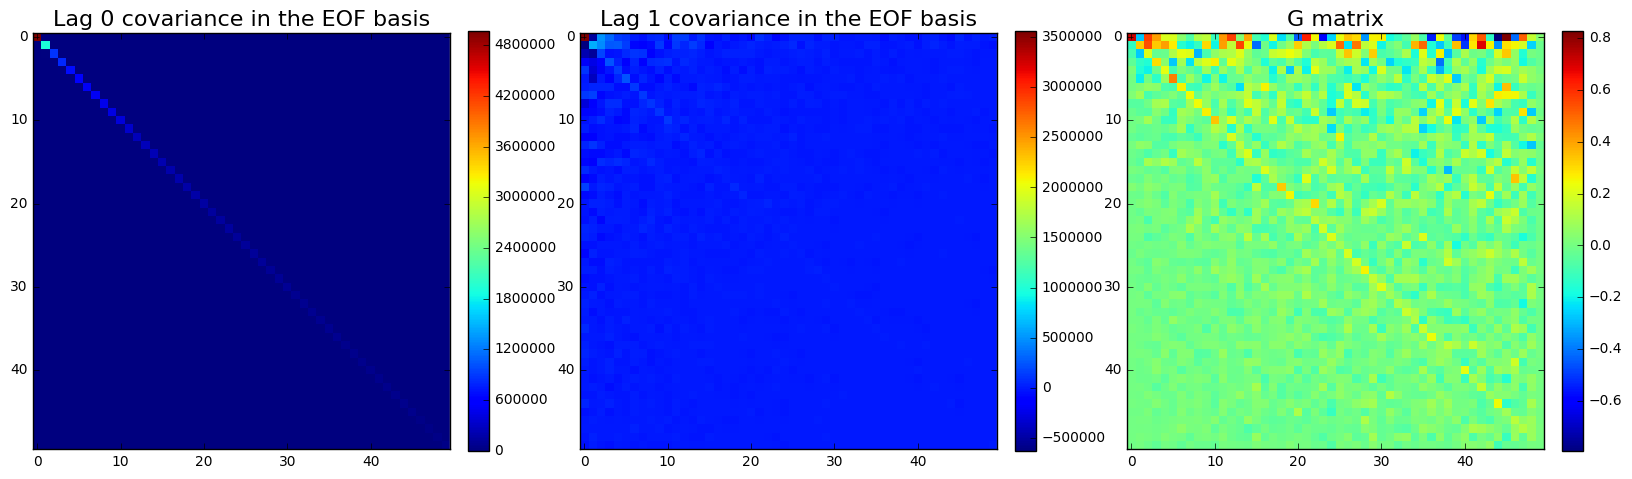

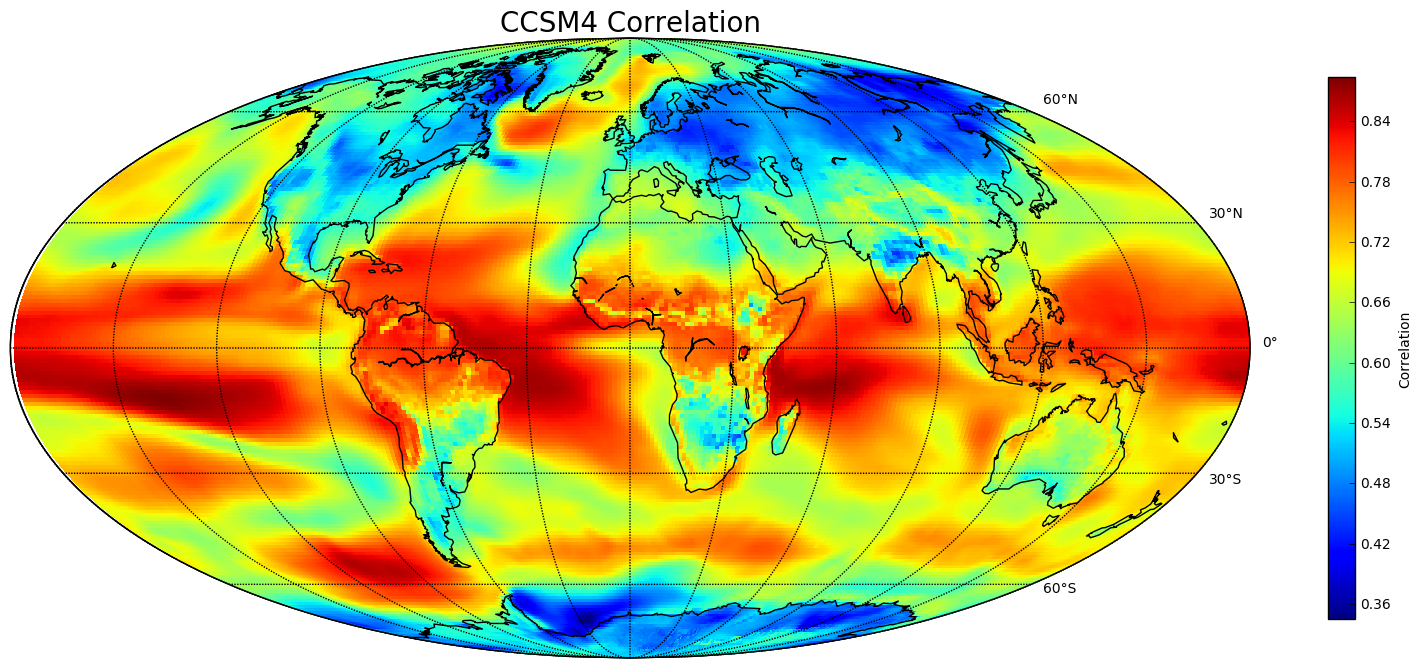

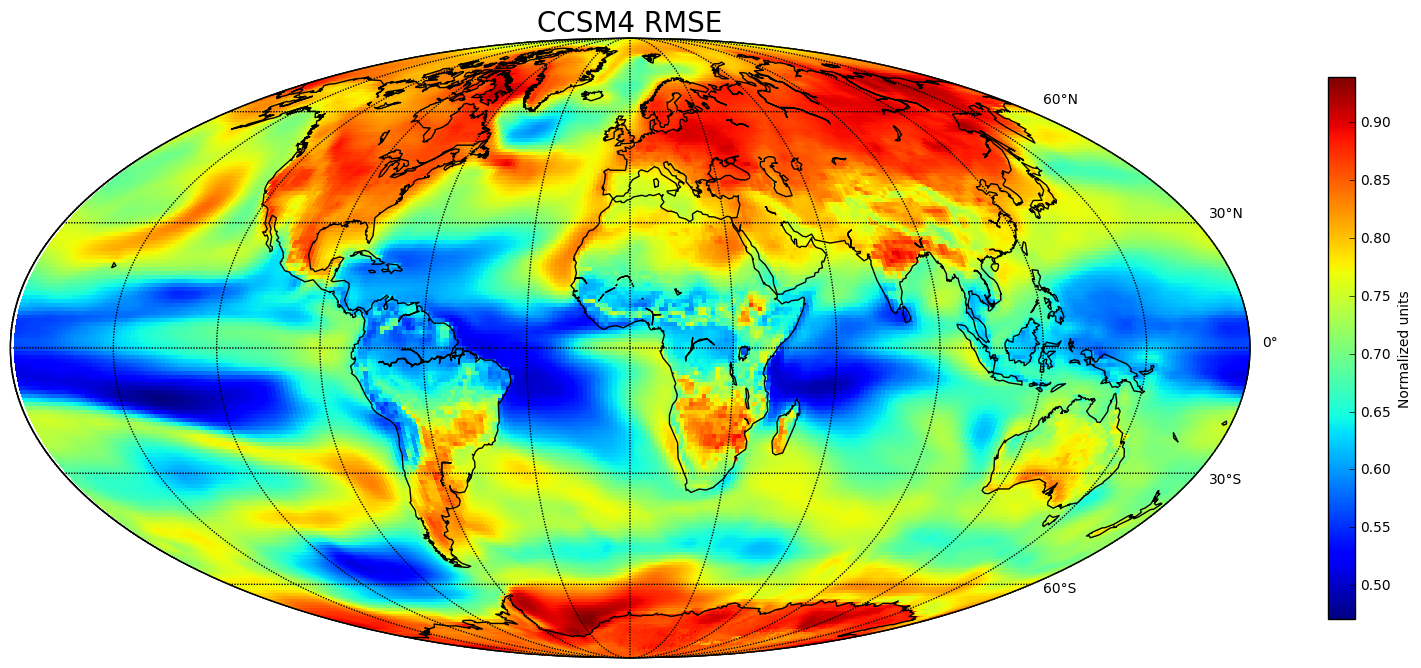

In [110]:
# Make a LIM from the leading 8 EOFs. Does it make sense? Does it improve prediction?

time = np.arange(850,1851)
data = np.reshape(dd['tas_sfc_Amon']['value'],[1001,-1])
ccsm4DF = pandas.DataFrame(data=data,index=time)

corrdf,rmsedf,G,c0,ct = getSkillGridded(ccsm4DF,1,[1100,1450],[1100,1450],True,50);

rmap = corrdf.values.reshape(192,288)
lon_g = dd['tas_sfc_Amon']['lon']
lat_g = dd['tas_sfc_Amon']['lat']

# Mask and plot with basemap

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

x,y = np.meshgrid(lon_g[:], lat_g[:])

ax = plt.gca()
masked_array = np.ma.array(rmap, mask=np.isnan(rmap))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,rmap,shading='flat',cmap=cmap,latlon=True);
#im2 = m.pcolormesh(x,y,masked_array,shading='flat',cmap=cmap,latlon=True);
m.drawcoastlines();
cbar = plt.colorbar(shrink=.7)
plt.title('CCSM4 Correlation',size=20)
cbar.set_label('Correlation')


rmap = rmsedf.values.reshape(192,288)
lon_g = dd['tas_sfc_Amon']['lon']
lat_g = dd['tas_sfc_Amon']['lat']

# Mask and plot with basemap

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

x,y = np.meshgrid(lon_g[:], lat_g[:])

ax = plt.gca()
masked_array = np.ma.array(rmap, mask=np.isnan(rmap))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,rmap,shading='flat',cmap=cmap,latlon=True);
#im2 = m.pcolormesh(x,y,masked_array,shading='flat',cmap=cmap,latlon=True);
m.drawcoastlines();
cbar = plt.colorbar(shrink=.7)
plt.title('CCSM4 RMSE',size=20)
cbar.set_label('Normalized units')

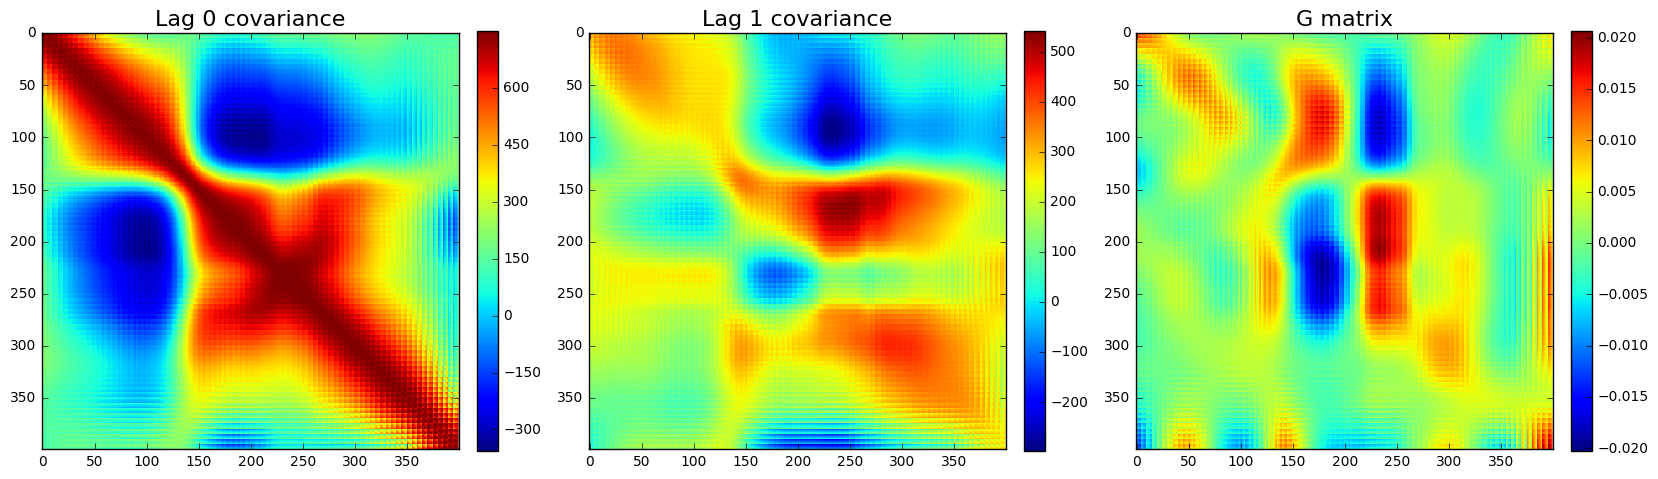

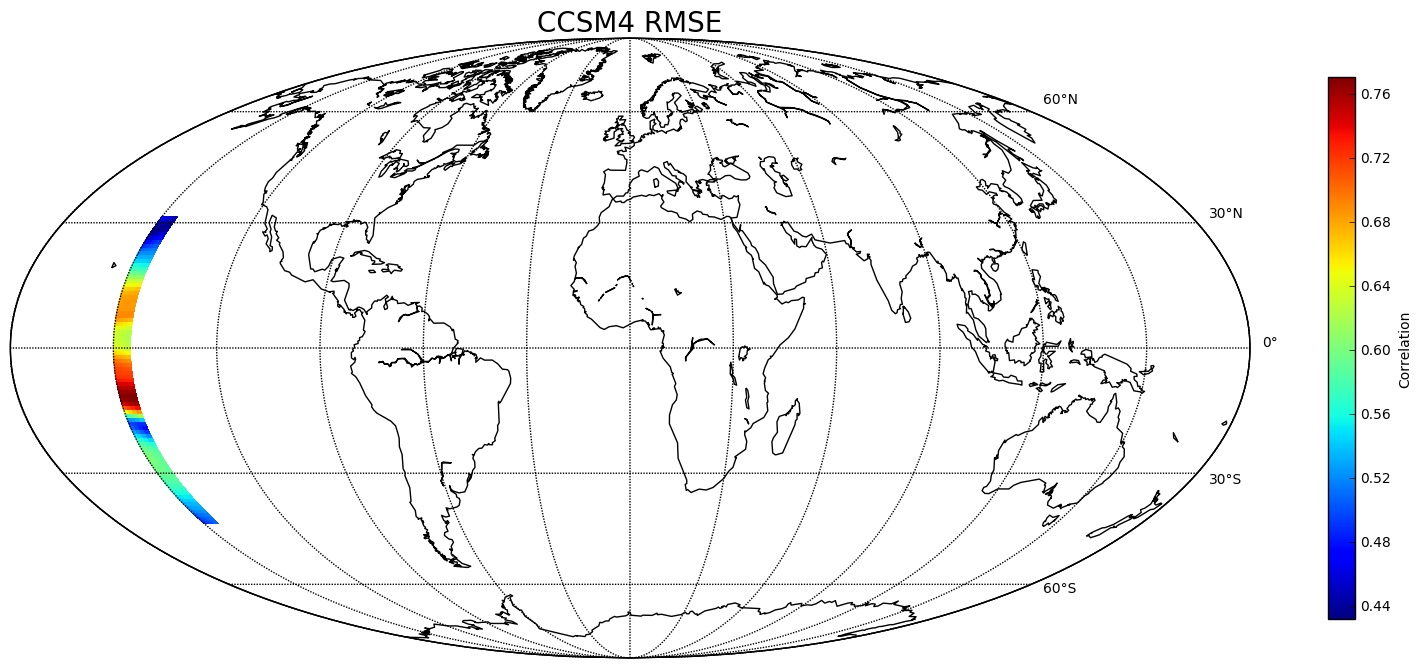

In [108]:
# Make a LIM for a subset of the domain in space

time = np.arange(850,1851)
lonrange = slice(168,173) # Pacific
#lonrange = slice(262,266) # Atlantic
latrange = slice(50,130)
datar = dd['tas_sfc_Amon']['value'][:,latrange,lonrange]

#datar = dd['tas_sfc_Amon']['value'][:,1:10,1:10]
_,llat,llon = datar.shape
data = np.reshape(datar,[1001,-1])
ccsm4DF = pandas.DataFrame(data=data,index=time)

corrdf,rmsedf,G,c0,ct = getSkillGridded(ccsm4DF,1,[1100,1950],[1100,1950],False);

rmap = corrdf.values.reshape(llat,llon)
lon_g = dd['tas_sfc_Amon']['lon'][lonrange]
lat_g = dd['tas_sfc_Amon']['lat'][latrange]

# Mask and plot with basemap

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

x,y = np.meshgrid(lon_g[:], lat_g[:])

ax = plt.gca()
masked_array = np.ma.array(rmap, mask=np.isnan(rmap))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,rmap,shading='flat',cmap=cmap,latlon=True);
#im2 = m.pcolormesh(x,y,masked_array,shading='flat',cmap=cmap,latlon=True);
m.drawcoastlines();
cbar = plt.colorbar(shrink=.7)
plt.title('CCSM4 RMSE',size=20)
cbar.set_label('Correlation')


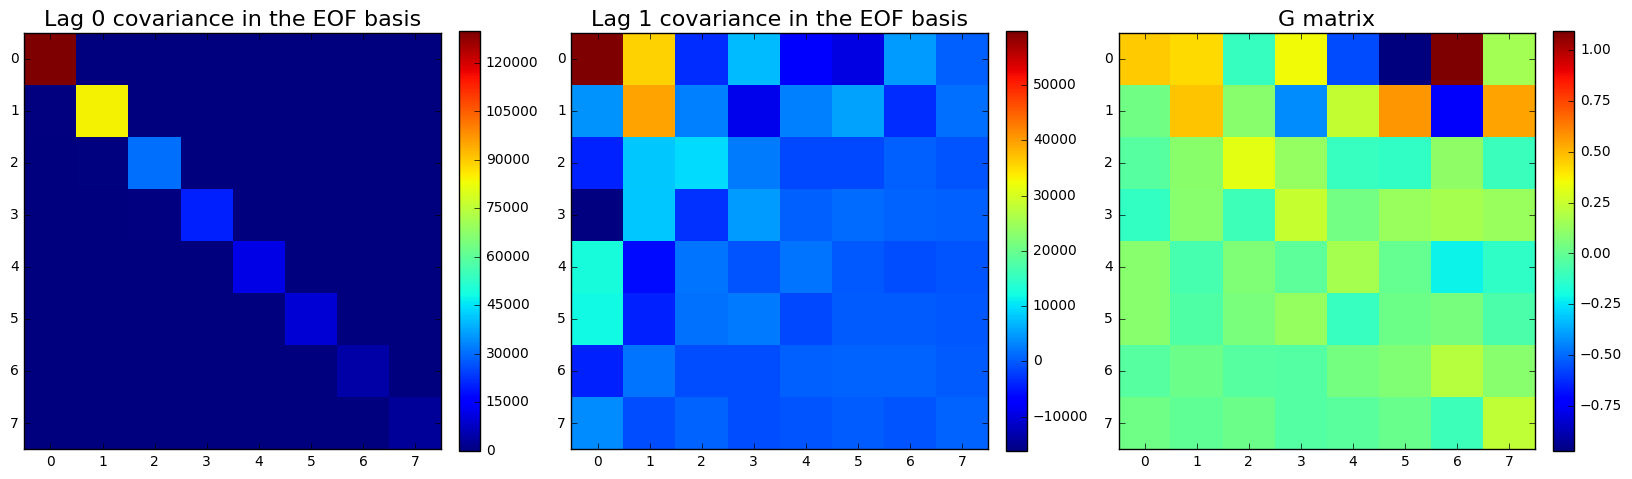

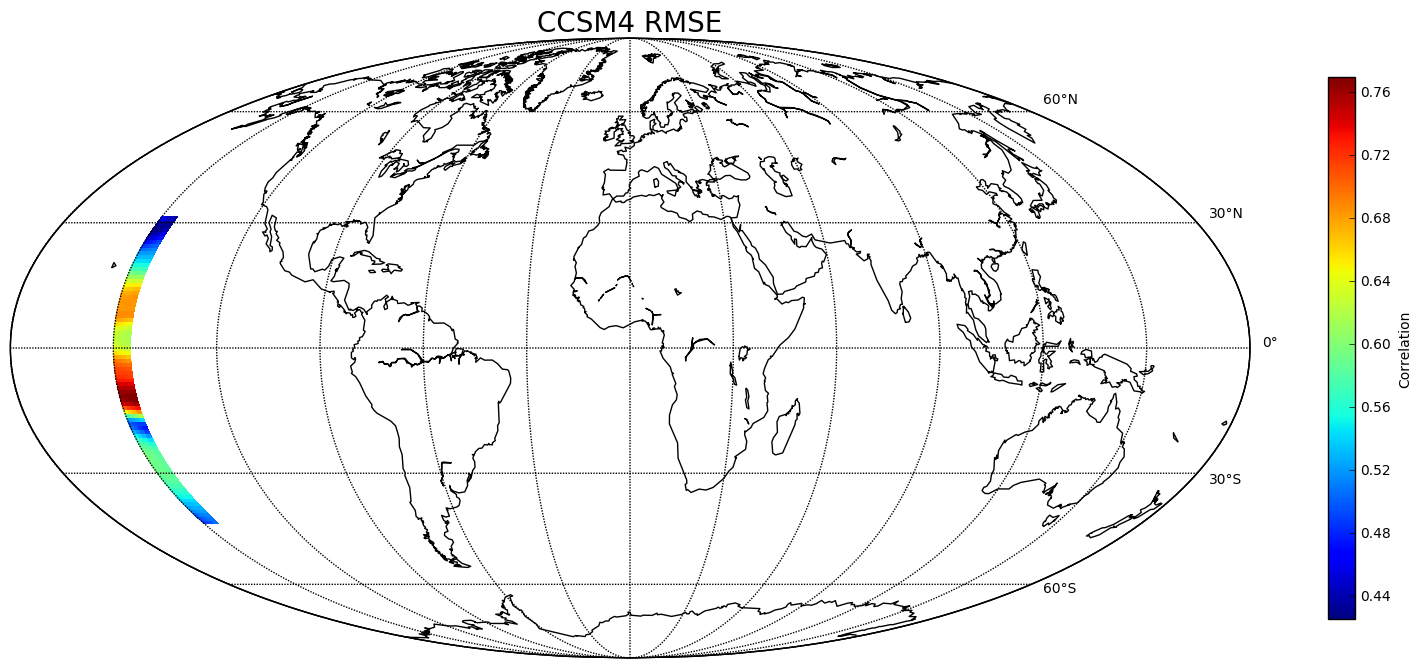

In [109]:
# Make a LIM for a subset of the domain in space
# Use EOFs

time = np.arange(850,1851)
lonrange = slice(168,173) # Pacific
#lonrange = slice(262,266) # Atlantic
latrange = slice(50,130)
datar = dd['tas_sfc_Amon']['value'][:,latrange,lonrange]

#datar = dd['tas_sfc_Amon']['value'][:,1:10,1:10]
_,llat,llon = datar.shape
data = np.reshape(datar,[1001,-1])
ccsm4DF = pandas.DataFrame(data=data,index=time)

corrdf,rmsedf,G,c0,ct = getSkillGridded(ccsm4DF,1,[1100,1950],[1100,1950],True,8);

rmap = corrdf.values.reshape(llat,llon)
lon_g = dd['tas_sfc_Amon']['lon'][lonrange]
lat_g = dd['tas_sfc_Amon']['lat'][latrange]

# Mask and plot with basemap

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

x,y = np.meshgrid(lon_g[:], lat_g[:])

ax = plt.gca()
masked_array = np.ma.array(rmap, mask=np.isnan(rmap))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,rmap,shading='flat',cmap=cmap,latlon=True);
#im2 = m.pcolormesh(x,y,masked_array,shading='flat',cmap=cmap,latlon=True);
m.drawcoastlines();
cbar = plt.colorbar(shrink=.7)
plt.title('CCSM4 RMSE',size=20)
cbar.set_label('Correlation')
